<a href="https://colab.research.google.com/github/RajBharti25/ILD/blob/master/ILD_model2_using_transfer_learning_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/

/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir


In [4]:
#installing the required libraries to read the Dicom files
pip install pydicom

     |████████████████████████████████| 35.3MB 123kB/s 


In [0]:
#Importing Library and other utils
import pydicom as dicom
import os
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cm
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

In [0]:
PathDicom = "/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/77"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
lstFilesDCM=sorted(lstFilesDCM)
RefDs = dicom.read_file(lstFilesDCM[0])

In [6]:
#Load the excel file with the label for each disease 
label=pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/clinicalParameters.csv')
label=label.iloc[:,:2]
label.head()

,id,diagnosis_category
0,3,pulmonary_fibrosis
1,7,tuberculosis
2,8,pulmonary_fibrosis
3,12,pneumocystis_pneumonia
4,13,pneumocystis_pneumonia


In [9]:
print('Name of Disease   :\t number of folder in datasets')
label.iloc[:,1].value_counts()

Name of Disease   :	 number of folder in datasets


pulmonary_fibrosis                          39
hypersensitivity_pneumonitis                23
sarcoidosis                                 19
tuberculosis                                15
pneumocystis_pneumonia                       8
cryptogenic_organizing_pneumonia             7
acute_interstitial_pneumonia                 4
nonspecific_interstitial_pneumonia           2
healthy                                      2
desquamative_interstitial_pneumonia          1
langerhans_cell_histiocytosis                1
respiratory_bronchiolitis_associated_ILD     1
lymphocytic_interstitial_pneumonia           1
eosinophilic_pneumonia                       1
Name: diagnosis_category, dtype: int64

In [62]:
label

,id,diagnosis_category
0,3,pulmonary_fibrosis
1,7,tuberculosis
2,8,pulmonary_fibrosis
3,12,pneumocystis_pneumonia
4,13,pneumocystis_pneumonia
...,...,...
119,181,pulmonary_fibrosis
120,182,sarcoidosis
121,183,sarcoidosis
122,184,pulmonary_fibrosis


In [31]:
temp_disease_list=['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'sarcoidosis','healthy']
required_folder=[]
for i in range(len(label)):
  if(label.iloc[i,1] in temp_disease_list):
    required_folder.append(i)
print('Number of folder containing required data:',len(required_folder))

Number of folder containing required data: 83


In [33]:
number_of_image=0
not_required=0
for i in range(185):
  if i in required_folder:
    dir='/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/'+str(i)+'/'
    for dirName, subdirList, fileList in os.walk(dir):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                number_of_image +=1
  else:
    dir='/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/'+str(i)+'/'
    for dirName, subdirList, fileList in os.walk(dir):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                not_required +=1

print('Total number of input image belonging to required Disease labels:',number_of_image)
print('Total number of input image  belonging to other Disease  labels :',not_required)

Total number of input image belonging to required Disease labels: 486
Total number of input image  belonging to other Disease  labels : 1155


In [78]:
start_time=time.time()
print('operation started')
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis','sarcoidosis', 'healthy'])
label_map={}
label_map_inverse={}
for l, x in enumerate(b):
  label_map[x]=l
  label_map_inverse[l]=x
temp_disease_list=['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'sarcoidosis','healthy']
image_number=0
train_label=[]
test_label=[]

#ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), number_of_image )
#Input_array=np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

for i in required_folder:
  dir='/content/drive/My Drive/Colab Notebooks/ILD/ILD on HRCT/Geneva HRCT Data/ILD_DB_txtROIs/'+str(i)+'/'
  for dirName, subdirList, fileList in os.walk(dir):
    j=0
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            temp_dir=dir+filename
            ref=dicom.read_file(temp_dir)
            Input_array=ref.pixel_array
            max_value=np.amax(Input_array)
            Input_array=Input_array/max_value
            im=Image.fromarray(np.uint8(cm.gray(Input_array)*255))
            arr=np.array(im)
            arr=arr[:,:,0:3]
            im=Image.fromarray(arr)
            if(j==len(fileList)/2 or j==0):
              im.save('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/'+str(image_number)+'.jpg')
              #filt_label=label[label['id']==i]
              #curr_label=filt_label.iloc[0,1]
              curr_label=label.iloc[i,1]
              test_label.append([str(image_number)+'.jpg',curr_label,label_map[curr_label]])
              j+=1
              image_number +=1
            else:
             im.save('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/'+str(image_number)+'.jpg')
             #filt_label=label[label['id']==i]
             #curr_label=filt_label.iloc[0,1]
             curr_label=label.iloc[i,1]
             train_label.append([str(image_number)+'.jpg',curr_label,label_map[curr_label]]) 
             j+=1
             image_number +=1
        if(image_number%100==0):
         print('Already processed ',image_number,' into jpg')

train_label1=pd.DataFrame(train_label)
test_label1=pd.DataFrame(test_label)

train_label1.to_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/train_label.csv',index=False)
test_label1.to_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv',index=False)

end_time=time.time()
print('operation_completed')
print('total time taken to complte: ',end_time-start_time,'seconds')

operation started
Already processed  0  into jpg
Already processed  100  into jpg
Already processed  200  into jpg
Already processed  300  into jpg
Already processed  400  into jpg
operation_completed
total time taken to complte:  17.205690145492554 min


In [0]:
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'tuberculosis',
       'sarcoidosis', 'pneumocystis_pneumonia', 'acute_interstitial_pneumonia',
       'healthy', 'eosinophilic_pneumonia',
       'desquamative_interstitial_pneumonia',
       'lymphocytic_interstitial_pneumonia'])
len(b)

10

In [0]:
# Transforming Image
image_transforms={
    #Data augmenation for training
    'train':
    transforms.Compose([
                        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                        #transforms.RandomRotation(degrees=15),
                        #transforms.ColorJitter(),
                        transforms.RandomHorizontalFlip(),
                        transforms.CenterCrop(size=224), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
                        transforms.Resize(size=225),
                        transforms.CenterCrop(size=224),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
} 

In [0]:
class HRCT_Dataset(Dataset):
  def __init__(self,csv_file, root_dir, transform=None):
    self.label = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  def __len__(self):
    return(len(self.label))
  
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.label.iloc[idx, 2]
        #sample = {'image': image, 'label': label}


        if self.transform:
            #sample['image'] = self.transform(sample['image'])
            image=self.transform(image)
            
        return image,torch.tensor(label)

In [0]:
hrct_dataset_train = HRCT_Dataset(csv_file='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/train_label.csv',
                                    root_dir='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/train/',
                                  transform=image_transforms['train'])
hrct_dataset_test = HRCT_Dataset(csv_file='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv',
                                    root_dir='/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/',
                                 transform=image_transforms['valid'])

In [84]:
len(hrct_dataset_train)

456

In [0]:
a,b=hrct_dataset_test[1]

In [0]:
a.shape,b.shape

(torch.Size([3, 224, 224]), torch.Size([1, 1]))

In [0]:
for i in range(len(hrct_dataset_test)):
    features,labels = hrct_dataset_test[i]

    print(i, features.shape, labels.shape)

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([1, 1])
1 torch.Size([3, 224, 224]) torch.Size([1, 1])
2 torch.Size([3, 224, 224]) torch.Size([1, 1])
3 torch.Size([3, 224, 224]) torch.Size([1, 1])


In [0]:
# Dataloader iterators, make sure to shuffle
hrct_dataloaders = {
    'train': DataLoader(hrct_dataset_train, batch_size=16,
                        shuffle=True, num_workers=4),
    'valid': DataLoader(hrct_dataset_test, batch_size=16,
                        shuffle=True, num_workers=4)
}

Previewing training images:



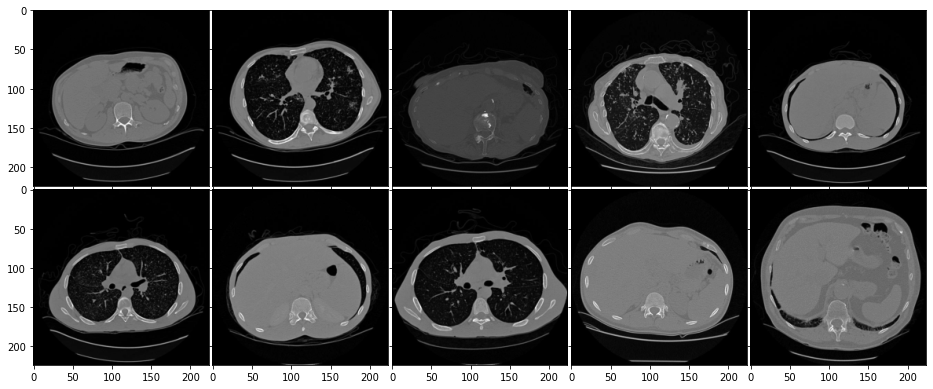

In [12]:
fig= plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
count=0
print('Previewing training images:\n')
for j in range(10):
  inputs, labels = hrct_dataset_test[j]
  ax = grid[count]
  ax.imshow(inputs[1,:,:], cmap='gray')
  #ax.text(10, 210, 'Label:'.format(labels.data[j]),color='k', backgroundcolor='w', alpha=0.8)
  count += 1


In [0]:
 # Iterate through the dataloader once
trainiter = iter(hrct_dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16, 1, 1]))

In [0]:
n_classes=4
batch_size=16

In [13]:
resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [89]:
#lets check our model
inputs, labels = next(iter(hrct_dataloaders['train']))
inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
outputs.shape

torch.Size([16, 1000])

In [0]:
# Freeze model weights
for param in resnet.parameters():
    param.requires_grad = False

#adding new layers with 10 classes 
num_ftrs=resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)


In [0]:
#Lets Define training parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects.double() / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
                'valid loss: {:.4f} acc: {:.4f}'.format(
                  epoch, num_epochs - 1,
                  train_epoch_loss, train_epoch_acc, 
                  valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [0]:
start_time = time.time()
model = train_model(hrct_dataloaders, resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))
torch.save(model,'resnet_weight.pt')

In [16]:
#loading the saved models parameter
# Model class must be defined somewhere
PATH='resnet_weight.pt'
model = torch.load(PATH)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Case # 2: Save model to resume training later: If you need to keep training the model that you are about to save, you need to save more than just the model. You also need to save the state of the optimizer, epochs, score, etc. You would do it like this:

```

state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    ...
}
torch.save(state, filepath)

```


To resume training you would do things like: state = torch.load(filepath), and then, to restore the state of each individual object, something like this:



```
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])
```



In [0]:
 #  Save model to resume training later
 PATH='resnet_weight.pt'
 state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    ...
}
torch.save(state, filepath)

In [0]:
# Load the values for continuing the training operation
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

Lets us visualize the performence of our model

In [0]:
b=(['pulmonary_fibrosis', 'hypersensitivity_pneumonitis', 'sarcoidosis','healthy'])
label_map={}
label_map_inverse={}
for l, x in enumerate(b):
  label_map_inverse[l]=x
  label_map[x]=l

In [0]:
def visualize_model_output(dataloders, model, num_images=16):
  count=0
  fig= plt.figure(1, figsize=(16, 28))
  
  (inputs,labels) = (next(iter(dataloders['valid'])))
  inputs, labels = Variable(inputs), Variable(labels)
  outputs= model(inputs)
  _,preds = torch.max(outputs.data, 1)
  print('Predictions for the 10 validation images   :',preds)
  print('Correct labels for the 10 validation images:',labels)

  print('\nBelow is the test image along with text in format prediction/Correct label\n')
  grid = ImageGrid(fig, 111, nrows_ncols=(2, 5), axes_pad=0.05)
  for j in range(10):
    ax = grid[count]
    ax.imshow( inputs.cpu().data[j,1,:,:], cmap='gray')
    ax.text(10, 210, '{}/{}'.format(label_map_inverse[preds[j].item()], label_map_inverse[labels.data[j].item()]),
            color='k', backgroundcolor='w', alpha=0.8)
    count += 1

Predictions for the 10 validation images   : tensor([0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0])
Correct labels for the 10 validation images: tensor([2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0])

Below is the test image along with text in format prediction/Correct label



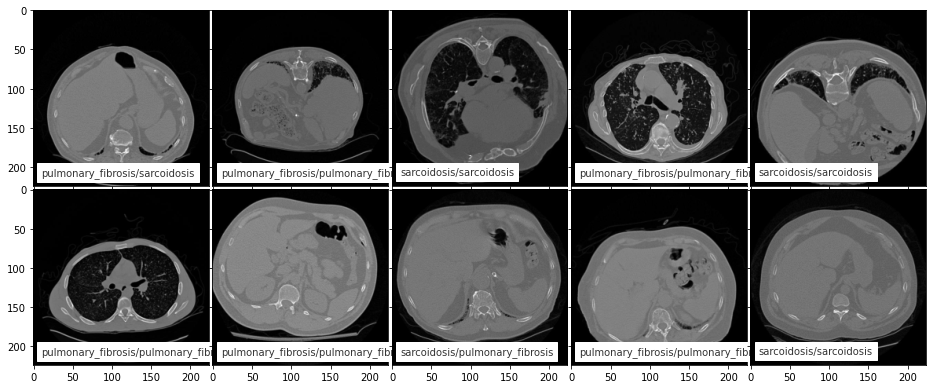

In [22]:
visualize_model_output(hrct_dataloaders, model)

In [0]:
len_valid=len(pd.read_csv('/content/drive/My Drive/Colab Notebooks/ILD/Working Directory/model2/root_dir/test/test_label.csv'))
valid_downloders=DataLoader(hrct_dataset_test, batch_size=len_valid,
                        shuffle=True, num_workers=4)

In [0]:
def predict_output(dataloders, model):
  count=0
  (inputs,labels) = (next(iter(dataloders)))
  inputs, labels = Variable(inputs), Variable(labels)
  outputs= model(inputs)
  _,preds = torch.max(outputs.data, 1)
  return (preds,labels)

In [0]:
# A function to return the "CONFUSION MATRIX" of the model predicted result
def create_confusion_matrix(preds, labels):
  stacked = torch.stack(
  (
      labels
      , preds
  ),dim=1
  )
  cmt = torch.zeros(4,4, dtype=torch.int64)
  for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1
  return cmt

In [27]:
(preds,labels) = predict_output(valid_downloders, model)
cmt = create_confusion_matrix(preds, labels)
print('Disease:Index ')
print(label_map)

print('\n\nnConfusion matrix->\n')
print(cmt)

Disease:Index 
{'pulmonary_fibrosis': 0, 'hypersensitivity_pneumonitis': 1, 'sarcoidosis': 2, 'healthy': 3}


nConfusion matrix->

tensor([[15,  0,  6,  0],
        [ 1,  1,  0,  0],
        [ 2,  0,  5,  0],
        [ 0,  0,  0,  0]])


In [71]:
preds==labels

tensor([False,  True,  True,  True,  True,  True,  True,  True, False, False,
         True, False,  True, False,  True, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False])

Previewing the attention map for out of first 25 of 64 11*11 kernels of the conv1 



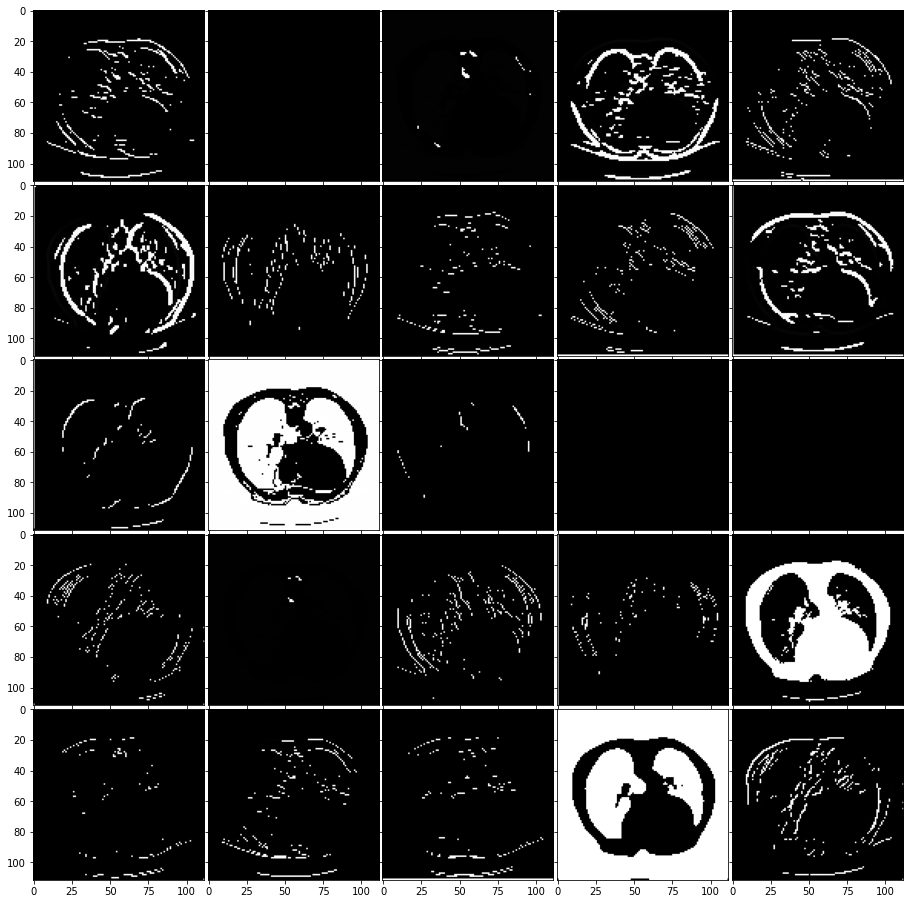

In [29]:
# Visualize feature maps
print('Previewing the attention map for out of first 25 of 64 11*11 kernels of the conv1 \n')
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
(inputs,labels) = (next(iter(valid_downloders)))
output = model(inputs)
act = activation['conv1'].squeeze()[0]
act=act.numpy()
fig= plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.05)
#fig, axarr = plt.subplots(4,4)
for idx in range(25):
  i=int(idx/5)
  j=idx-5*i
  c=np.array(Image.fromarray(act[idx].astype(np.uint8)))
  grid[idx].imshow(c,cmap='gray')